In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [0]:
meta_data = pd.read_csv("drive/My Drive/input/skincancer_metadata.csv")

In [0]:
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [0]:
base_skin_dir = os.path.join('drive/My Drive/','input')

In [0]:
base_skin_dir

'drive/My Drive/input'

In [0]:
imagid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir,'*','*.jpg'))}

In [0]:
lession_type_dict = {'nv':'Melanocytic nevi','mel':'Melanoma','bkl':'Benign Keratosis-like lesions','bcc':'Basal Cell Carcinoma','akiec':'Actinic Keratoses','vasc':'Vascular Lessions','df':'Dermatofibroma'}

In [0]:
lession_type_dict

{'akiec': 'Actinic Keratoses',
 'bcc': 'Basal Cell Carcinoma',
 'bkl': 'Benign Keratosis-like lesions',
 'df': 'Dermatofibroma',
 'mel': 'Melanoma',
 'nv': 'Melanocytic nevi',
 'vasc': 'Vascular Lessions'}

In [0]:
skin_df = pd.read_csv(os.path.join(base_skin_dir,'skincancer_metadata.csv'))

In [0]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [0]:
skin_df['path'] = skin_df['image_id'].map(imagid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lession_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [0]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,drive/My Drive/input/HAM10000_images_part_1/IS...,Benign Keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,drive/My Drive/input/HAM10000_images_part_1/IS...,Benign Keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,drive/My Drive/input/HAM10000_images_part_1/IS...,Benign Keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,drive/My Drive/input/HAM10000_images_part_1/IS...,Benign Keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,drive/My Drive/input/HAM10000_images_part_2/IS...,Benign Keratosis-like lesions,2


In [0]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [0]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [0]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [0]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


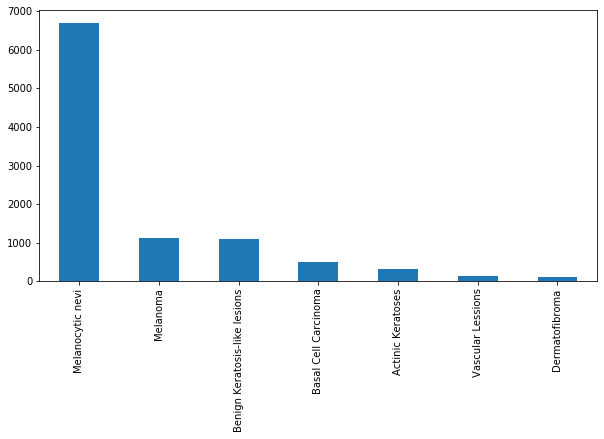

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))


In [0]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,drive/My Drive/input/HAM10000_images_part_1/IS...,Benign Keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,drive/My Drive/input/HAM10000_images_part_1/IS...,Benign Keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,drive/My Drive/input/HAM10000_images_part_1/IS...,Benign Keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,drive/My Drive/input/HAM10000_images_part_1/IS...,Benign Keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,drive/My Drive/input/HAM10000_images_part_2/IS...,Benign Keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


In [0]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [0]:
features=skin_df[['image']]
target=skin_df['cell_type_idx']

In [0]:
features.head()

,image
0,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


In [0]:


x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)



In [0]:
x_train_o.head()

,image
8442,"[[[157, 115, 127], [162, 122, 133], [164, 126,..."
2908,"[[[202, 149, 167], [200, 143, 160], [199, 144,..."
8909,"[[[184, 164, 157], [188, 168, 161], [188, 168,..."
58,"[[[29, 18, 24], [34, 21, 28], [41, 25, 36], [5..."
2960,"[[[152, 101, 97], [154, 101, 95], [156, 107, 1..."


In [0]:
y_train_o.head()

8442    4
2908    1
8909    4
58      2
2960    1
Name: cell_type_idx, dtype: int8

In [0]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [0]:


# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)



In [0]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [0]:


x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)



In [0]:


# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))



Step 11: Model Building

In [0]:
input_shape = (75, 100, 3)
num_classes = 7


In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 50, 64)        36928     


In [0]:

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [0]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
learning_rate_reduction

In [0]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [0]:
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





721/721 [==============================] - 315s 437ms/step - loss: 1.0241 - acc: 0.6662 - val_loss: 0.8878 - val_acc: 0.6820
Epoch 2/50
721/721 [==============================] - 313s 433ms/step - loss: 0.9133 - acc: 0.6750 - val_loss: 0.8692 - val_acc: 0.6945
Epoch 3/50
721/721 [==============================] - 313s 434ms/step - loss: 0.8858 - acc: 0.6803 - val_loss: 0.8992 - val_acc: 0.6945
Epoch 4/50
721/721 [==============================] - 313s 434ms/step - loss: 0.8724 - acc: 0.6838 - val_loss: 0.8208 - val_acc: 0.6870
Epoch 5/50
721/721 [==============================] - 312s 432ms/step - loss: 0.8404 - acc: 0.6928 - val_loss: 0.7869 - val_acc: 0.7032
Epoch 6/50
721/721 [==============================] - 311s 431ms/step - loss: 0.8112 - acc: 0.6994 - val_loss: 0.7650 - val_acc: 0.7232
Epoch 7/50
721/721 [==============================] - 312s 433ms/step - loss: 0.80

In [0]:
x_train[0].shape


(75, 100, 3)

In [0]:
x = x_test[0]

In [0]:
x_test.shape

(2003, 75, 100, 3)

In [0]:
x_test[0].shape

(75, 100, 3)

In [0]:
history

In [0]:
x = x_test[0]


In [0]:
x = np.asarray([x])

In [0]:
model.predict(x)

array([[1.3855526e-08, 9.2476125e-07, 1.4183602e-03, 2.5556888e-04,
        9.9831712e-01, 7.9704087e-06, 1.5015532e-07]], dtype=float32)

In [ ]:
model.save('sample_data/model1.h5')

In [0]:
c = c.tolist()

In [0]:
c

[5.136232772429139e-08,
 1.5315208656829782e-05,
 0.02202741801738739,
 4.8284440708812326e-05,
 0.9764699339866638,
 0.0014389510033652186,
 4.054749069837271e-08]

In [0]:
max(c)

0.9764699339866638

In [0]:
c.index(max(c))

4

In [0]:
x_train[0].shape

(75, 100, 3)

In [0]:
type(skin_df)

pandas.core.frame.DataFrame

In [ ]:
skin_df.to_csv('/sample_data/skin.csv')